In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline
# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
#import numpy as np
import sys
sys.path.append("../../")
from pandas import read_html
from netCDF4 import Dataset #pip install netCDF4
from modsim import *
import numpy.ma as ma
from matplotlib.pyplot import *
from datetime import date as dt
from scipy.interpolate import UnivariateSpline

# Project 2
# Noor & Konrad


Climate change has brought with it a fair number of extreme weather phenomena, some of which include wildfires, droughts, and cyclones. Hurricanes are especially under spotlight after the devastating effects of hurricane Dorian in the Bahamas. Driven by the news of rising ocean temperatures and its effects on hurricane intensity, we set out to investigate the relationships between sea surface temperatures (SST) and the resulting power generated and wind speeds during hurricanes.

## Question 
More specifically, we looked at data for hurricane Dorian and asked: "As SSTs increased during hurricane Dorian, how did the resulting power output and wind speed change? More pressingly - as SSTs increase in the future, how can we expect the intensity of future hurricanes to change?"

## Main Model
Weather modeling is hard enough for experts, so we knew we were taking on a pretty complicated task. To make it simpler and concise, we only looked at the effects of atmosphere temperature (${T_O}$) and sea surface temperature (${T_S}$) on power output and wind speeds. These weren't the greatest assumptions because there are more factors to a hurricane than (${T_O}$) and (${T_S}$) e.g. wind shear and air moisture. 

It's worth noting that the atmospheric layer we're looking at is the tropopause - the boundary between the troposphere and stratosphere!

#### Equation Run-Through

Our equation for **Power** is $P=efficiency*heatin'$ where $efficiency=(T_S-T_O)/T_S$ and $heatin'= v*E$ (where v is surface wind speed and E is the surface air-sea enthalpy difference).

Our equation for **Wind Speed** is $v = \sqrt{(C_k/C_d)/((T_S-T_O)/T_O)*\Delta k}$. We assume the ratio of enthalpy and momentum surface exchange coefficients, $(C_k/C_d)$, is 1, which is an assumption  made in some research papers - if it's good enough for them, good enough for us! 

$\Delta k$ is the air-sea enthalpy difference (unit is Joules) and we calculate it with the equation $\Delta k = C_p\Delta TL_v\Delta q$, where $C_p$ is the heat capacity of air ($1.03*10^3 J{kg}^{-1} K^{-1}$), $L_v$ is the latent heat of evaporation ($2.25*10^6 J{kg}^{-1}$), $\Delta T$ is the temperature difference betwee SST and air temperature at 2m, and $\Delta q$ is the same thing except for humidity. We assume $\Delta T \approx 3K$ although this is a human estimate and not a very well-rooted assumption. We assume $\Delta q \approx$ 0.8 based on research.

#### Code Run-Through
Much of the code below this is set-up that lets us initialize the variables we'll need to keep track of things and get in data from our HTML and netCDF4 (a huge pain) files.

In [2]:
# Dictionary to help convert website dates for Dorian to data dates
dates = {"Aug 24":"0824", "Aug 25":"0825", "Aug 26":"0826",
         "Aug 27":"0827","Aug 28":"0828", "Aug 29":"0829", 
         "Aug 30":"0830", "Aug 31":"0831", "Sep 1":"0901", 
         "Sep 2":"0902", "Sep 3":"0903", "Sep 4":"0904", 
         "Sep 5":"0905", "Sep 6":"0906", "Sep 7":"0907", 
         "Sep 8":"0908", "Sep 9":"0909"}

{'Aug 24': '0824',
 'Aug 25': '0825',
 'Aug 26': '0826',
 'Aug 27': '0827',
 'Aug 28': '0828',
 'Aug 29': '0829',
 'Aug 30': '0830',
 'Aug 31': '0831',
 'Sep 1': '0901',
 'Sep 2': '0902',
 'Sep 3': '0903',
 'Sep 4': '0904',
 'Sep 5': '0905',
 'Sep 6': '0906',
 'Sep 7': '0907',
 'Sep 8': '0908',
 'Sep 9': '0909'}

In [30]:
# Read in the HTML with data for the Dorian Hurricane 
dorian = read_html("https://docs.google.com/spreadsheets/d/1RcL7__cwpEwNGeKXvZhflQyn0UEtCoyeBpBuJsAtJCs/edit?usp=sharing", header=0, index_col=0)[0]

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
1,Aug 24,15:00 GMT,10.4Â°,-47.9Â°,35mph,1010mb,Tropical Depression,-,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aug 24,21:00 GMT,10.7Â°,-49.1Â°,40mph,1008mb,Tropical Storm,-,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aug 25,03:00 GMT,10.9Â°,-50.4Â°,40mph,1008mb,Tropical Storm,-,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aug 25,09:00 GMT,11.0Â°,-51.6Â°,40mph,1008mb,Tropical Storm,-,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Aug 25,12:00 GMT,11.1Â°,-52.1Â°,40mph,1008mb,Tropical Storm,-,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Sep 3,04:00 GMT,26.8Â°,-78.4Â°,130mph,950mb,Hurricane,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Sep 3,05:00 GMT,26.8Â°,-78.4Â°,125mph,950mb,Hurricane,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Sep 3,06:00 GMT,26.9Â°,-78.4Â°,120mph,950mb,Hurricane,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,Sep 3,07:00 GMT,26.9Â°,-78.4Â°,120mph,950mb,Hurricane,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Lists of lat/lon values that match up to Dorian's path
lat_list = dorian['C']
lon_list = dorian['D']
# Corresponding dates
date_list = dorian['A'] 

1      Aug 24
2      Aug 24
3      Aug 25
4      Aug 25
5      Aug 25
        ...  
96      Sep 3
97      Sep 3
98      Sep 3
99      Sep 3
100     Sep 3
Name: A, Length: 100, dtype: object

#### Notes on Data Files
We found datasets for $T_O$ and $T_S$ with some hair-pulling, eventually from the National Oceanic and Atmospheric Administration (NOAA). $T_O$ is a consolidated data set while for $T_S$, we found data for each day Dorian was occuring and put it in the SSTdata folder - each dataset is named with the format: {two-digit month number}{two-digit day}.

The data for both was collected (not by us) by dividing the Earth into grids and measuring daily tropopause temperatures/SST values for each grid. We can then get temperatures as needed by inputting a date (0, in the case for SST data since it's already date-specific) and the closest grid for our longitude/latitude values.

An example of the netCDF4 file setup is below, for the $T_O$ data set.

In [5]:
# Create lists of sea surface temperatures (Ts) and outer air temperatures (To)
Ts_list = []
To_list = []

# We initialize it here because we only need the one set
To = Dataset("To.nc", mode="r")

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: mean daily NMC reanalysis (2014)
    history: created 2017/12 by Hoop (netCDF2.3)
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the tropopause values.
    platform: Model
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html
    dataset_title: NCEP-NCAR Reanalysis 1
    dimensions(sizes): lat(73), lon(144), time(318), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 air(time,lat,lon), float64 time_bnds(time,nbnds)
    groups: 

The next two cells contain the functions **calc_To()** and **calc_Ts()**. Both of these perform essentially the same tasks: it takes in a given day, latitude (N) and longitude (E) and uses that information to find the tropopause and SST temperatures (respectively) at that specific date and location.

In [6]:
'''Calculates To values given the day, latitude, and longitude'''
def calc_To(date, lat, lon):
    #Get the date we're looking at
    month, day = int(date[0:2]), int(date[2:4])#takes first two characters to get a month number and last two to get a day number
    diff = (dt(2019,month, day)-dt(1800, 1, 1))#calculates difference in time between date and Jan 1, 1800
    time = (np.abs(To.variables['time'][:] - diff.days*24)).argmin()#index to the minimum elapsed time since date
    
    #Get the appropriate indices for our lat and lon
    #by finding smallest difference between variables of lat and lon in To and the lat and lon of interest
    lat_index = (np.abs(To.variables['lat'][:] - lat)).argmin()
    lon_index = (np.abs(To.variables['lon'][:] - lon)).argmin()
    
    air_temp = To.variables['air']
    To_list.append(air_temp[time, lat_index, lon_index]) #In Kelvin as required for thermo equations

In [7]:
'''Calculates Ts values given the day, latitude, and longitude'''
def calc_Ts(date, lat, lon):
    #Get data for the new day
    Ts = Dataset("SSTdata/{}.nc".format(date), mode="r")
    
    #Get the closest index to the lat/lon values we have
    lat_index = (abs(Ts.variables['lat'][:] - lat)).argmin()
    lon_index = (abs(Ts.variables['lon'][:] - lon)).argmin()
    
    sst = Ts.variables['analysed_sst']
    Ts_list.append(sst[0, lat_index, lon_index]) #In Kelvin as required for thermo equations

Once our calculation functions have been set up, we can run the following loop to go through each date in our DataFrame, parse Dorian's latitude and longitude on that day, and update our **Ts_list** and **To_list** accordingly.

In [8]:
'''For as long as our DataFrame is, calculate Ts and To for each entry'''
for i in range(len(dorian)):
    website_date = date_list[i+1]
    date = dates[website_date]
    
    index = dorian.index[i]
    #removing the last two characters to make a unitless number
    lat = float(lat_list[index][:-2]) 
    lon = 360+float(lon_list[index][:-2]) #W to E
    
    calc_Ts(date, lat, lon)
    calc_To(date, lat, lon)

When we plot our **Ts_list** and **To_list**, we can see how large the difference between temperatures at sea level and high up in the atmosphere is - the tropopause is at a chilly -99F while the sea is at a comfy 80F!

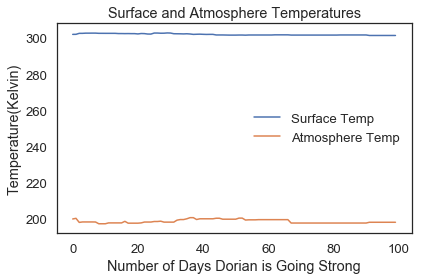

In [9]:
#Temperature of air at the surface of the ocean in Kelvin.  
plot(Ts_list, label='Surface Temp')
#Temperature in the atmosphere at 75 kilometers is about 200 Kelvin according to the CRC 68th Ed Table F141 which is consistant with the data.
plot(To_list, label='Atmosphere Temp')
decorate(ylabel='Temperature(Kelvin)', 
         xlabel='Number of Days Dorian is Going Strong',
         title='Surface and Atmosphere Temperatures')

Below is the function that actually goes through a hurricane's timeline and calculates the power and wind speed at each unit of time. We've made it a generalized function that could work with any list of sea and air temperatures, so it isn't quite Dorian-specific. 

What **calcPowerAndVelocity** does is go through one of the lists (either **sea** or **air** should work, we're assuming they'll be the same length), calculates the velocity and then calculates the power according to the equations we discussed at the beginning of this essay. It then returns a handy-dandy tuple comprised of the resulting **power** and **velocity** lists.

In [17]:
# Calculate hurricane's power & efficiency given lists of ocean/air temps
def calcPowerAndVelocity(sea, air, humid):
    power = []
    velocity = []
    for i in range(len(sea)):
        #Equation below from Hurricane Alley paper
        disequilibrium = (1.03e3)*3*2.25e6*humid #Joules   
        velocity.append(ma.sqrt(0.7*disequilibrium*(sea[i]-air[i])/air[i]))
        
        efficiency = (sea[i]-air[i])/sea[i] #Unitless
        #Equation below from Emmanuel 2006 
        heatin_prime= velocity[-1]*disequilibrium 
        power.append(efficiency * heatin_prime)
        
    return power, velocity
currHumid = 0.8
dorian_power, dorian_velocity = calcPowerAndVelocity(Ts_list, To_list, currHumid)

For the sake of curiosity, we can see how power and windspeed vary by SST and tropopause temperatures by graphing the following scatter plots:

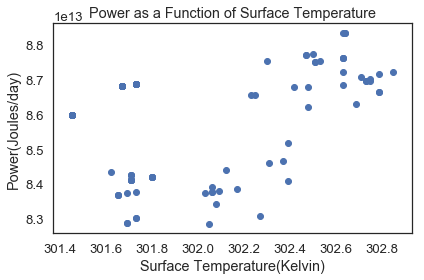

In [19]:
#Plotting dorian_power versus surface temperature
scatter(Ts_list,dorian_power)
decorate(ylabel='Power(Joules/day)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Power as a Function of Surface Temperature')

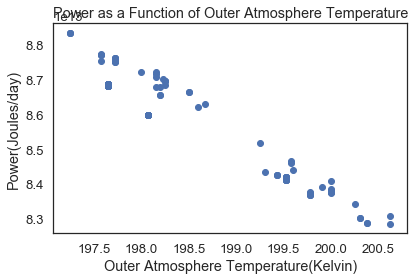

In [20]:
#Plotting dorian_power versus outer atmosphere temperature
scatter(To_list,dorian_power)
decorate(ylabel='Power(Joules/day)', 
         xlabel='Outer Atmosphere Temperature(Kelvin)',
         title='Power as a Function of Outer Atmosphere Temperature')

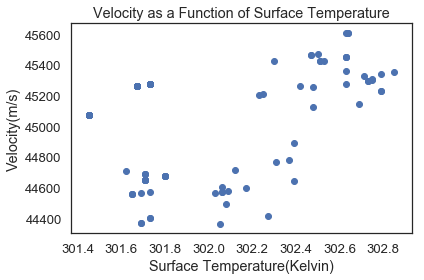

In [21]:
#Plotting dorian_velocity versus surface temperature
scatter(Ts_list,dorian_velocity)
decorate(ylabel='Velocity(m/s)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Velocity as a Function of Surface Temperature')

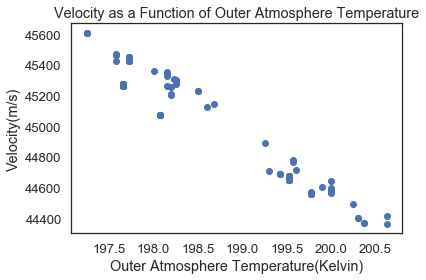

In [22]:
#Plotting dorian_velocity versus outer atmosphere temperature
scatter(To_list,dorian_velocity)
decorate(ylabel='Velocity(m/s)', 
         xlabel='Outer Atmosphere Temperature(Kelvin)',
         title='Velocity as a Function of Outer Atmosphere Temperature')

The data above for hurricane Dorian indicates that the variation in atmosphere temperature had a greater affect on the hurricane wind velocity and power than the variation in the ocean surface temperature. While it isn't as strong, we can see a positive relationship between higher SST's and wind speed/velocity.

We can also see that higher temperatures in the tropopause strongly correlate to lower wind speeds and power, which isn't very intuitive until you remember that a hurricane's intensity depends on the energy difference between the ocean and the upper atmosphere - a higher $T_O$ means the energy difference isn't as large!

### Quick Note on Scale
So you can see that both the power and wind speed is on a pretty large scale - 1e13 for power and 1e4 for wind speed, which is incredibly high. While the power itself may still be reasonable after researching articles about hurricane power outputs, we can easily debunk the scale for wind speed with our Dorian DataFrame above. So why is it so high?

#### Carnot Heat Engine
Our theory for this is because the equations we're using for power output and wind velocity are based on treating hurricanes as idealized Carnot heat engines, where efficiency is maximised, but that isn't necessarily the case because in real life where energy is lost through various means (evaporation, rainfall, etc.) and we aren't taking those into account. Related to this, our equations are definitely not as sophisticated or nuanced as what scientists normally use when they're analysing hurricanes, even if they're using the Carnot engine simplification!

*Back to our model!*

Now that we've explored the relationships and correlations between air and sea temperatures with Dorian's power output and wind speeds, we can investigate how these power outputs and wind speeds change if sea surface temperatures increased.

The following code sequentially increases the values in our **Ts_list** by 1K and calculates the resulting change in power output and wind velocity.

In [23]:
#Creating power_changes, velocity_changes, and Ts_changes.
Ts_add_range = linspace(0, 5, 6)

power_changes = DataFrame()
velocity_changes = DataFrame()
Ts_changes = DataFrame()

for add in Ts_add_range:
    added_Ts_list = [x+add for x in Ts_list]
    p, v = calcPowerAndVelocity(added_Ts_list, To_list, currHumid)
    line_label = "+" + str(add) + "K"
    
    Ts_changes[line_label] = added_Ts_list
    power_changes[line_label] = p
    velocity_changes[line_label] = v

## Results

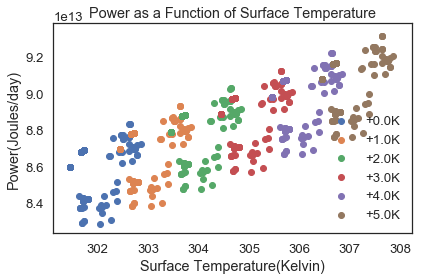

In [24]:
#Plotting hurricane power with increasing ocean surface temperature.
for outputs in power_changes.columns:
    scatter(Ts_changes[outputs], power_changes[outputs])
    
decorate(ylabel='Power(Joules/day)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Power as a Function of Surface Temperature')

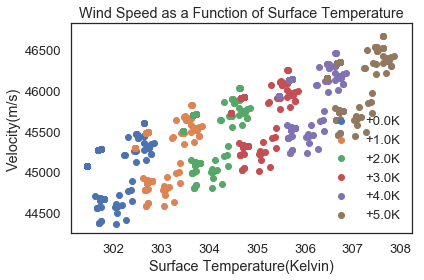

In [25]:
#Plotting hurricane wind speed velocity with increasing ocean surface temperature.
for speeds in velocity_changes.columns:
    scatter(Ts_changes[speeds], velocity_changes[speeds])

decorate(ylabel='Velocity(m/s)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Wind Speed as a Function of Surface Temperature')

We can see that both wind speed and power output increase as temperatures increase, but the results aren't very interesting - it essentially is  the same scatter plot but shifted upwards, which doesn't't feel very realistic.

The code above only increases $T_S$ and keeps all other variables constant - after seeing the results of our first model, we decided to add more complexity and see how our model changes.

## Model Iteration
To add this complexity, we first looked at $T_S$ and decided a non-linear increase would be more realistic because online research pointed to non-linear increases in projected ocean temperatures.

In [26]:
Ts_add_range = [0.25, 0.5, 1, 2, 4, 8, 16, 32]

power_changes = DataFrame()
velocity_changes = DataFrame()
Ts_changes = DataFrame()

""


We then set up our loop as usual, adding the SST changes to added_Ts_list with the additional step of increasing tropopause temperatures in $T_O$. 

We increase values in **To_list** by (value added to **Ts_list**) * 2.2/4. We use 2.2/4 specifically because of a paper by Lin et. al. in 2014, where they investigated the effects of a 4K increase in SST on tropopause temperatures and (generally) came up with an increase of 2.2K.

Additionally, we finally make use of the last parameter in calcPowerAndVelocity and update the difference in humidity ($\Delta q$) by 0.07 for every 1K increase. This is based on information from a post by Held in 2014 called "Relative humidity over oceans."

In [27]:
for add in Ts_add_range:
    added_Ts_list = [x+add for x in Ts_list]
    added_To_list = [x+(add*(2.2/4)) for x in To_list]
    #Delta q increase is projected as 0.07 per 1K increase
    newHumid = currHumid + 0.07*add
    
    p, v = calcPowerAndVelocity(added_Ts_list, added_To_list, newHumid)
    line_label = "+" + str(add) + "K"
    
    Ts_changes[line_label] = added_Ts_list #mainly looking at SST, not tropopause
    power_changes[line_label] = p
    velocity_changes[line_label] = v

## Iteration Results

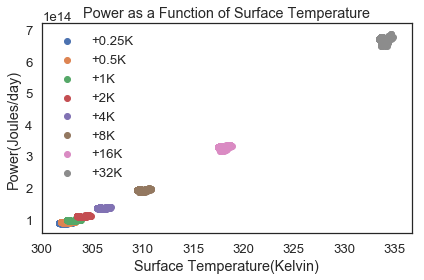

In [28]:
#Plotting hurricane power against ocean surface temperature with an assumed global warming.  
for outputs in power_changes.columns:
    scatter(Ts_changes[outputs], power_changes[outputs])
    
decorate(ylabel='Power(Joules/day)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Power as a Function of Surface Temperature')

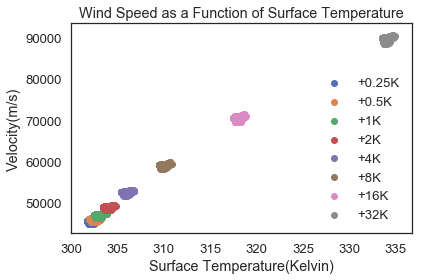

In [29]:
#Plotting hurricane power against ocean surface temperature with an assumed global warming.  
for speeds in velocity_changes.columns:
    scatter(Ts_changes[speeds], velocity_changes[speeds])

decorate(ylabel='Velocity(m/s)', 
         xlabel='Surface Temperature(Kelvin)',
         title='Wind Speed as a Function of Surface Temperature')

The results here seem more realistic but very curious! It tells us that as SSTs increase in the very far future, a Dorian-similar hurricane's power output would keep increasing non-linearly but its wind speeds would increase but taper off at a point. 

It takes a close eye (and a ruler) to see it but the plots for power increase at an increasing rate, while the plots for velocity increase but at a decreasing rate.

## Interpretation
Our iteration than gives us the more useful and interesting answer to our modeling question - that as our oceans warm in the far future, hurricanes will output an increasing amount of power but wind speeds will only increase up to a point!

Of course, it's entirely possible that our model is completely wrong because of the many assumptions we've made for our equations and what goes into our equations. Another source of error could be the data we collected from research papers (and the internet), because it's possible that we missed key points vital to the data's relevance for us.

### Role of Iteration
Our iteration was a good lesson in learning that sometimes it's worth it to go the extra mile and add a little more complexity to our model!